# IOU/AFL/MAFL Plots

We find that the results are consistent throughout these metrics: as model reasoning gets more complex, acute failure modes are revealed for all methods.

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import smerf
from smerf.models import *
from smerf.textbox_data import *
from smerf.eval import *
import smerf.explanations as saliency
import pickle
import os
import glob

# Set up the directory where the intermediary/final results are saved
CACHE_DIR = '../outputs/cache'
if not os.path.exists(CACHE_DIR):
    os.mkdir(CACHE_DIR)
    
PLOT_DIR = '../outputs/plots'
if not os.path.exists(PLOT_DIR):
    os.mkdir(PLOT_DIR)
    
exp_no = 2.11
methods_name =  os.path.join(CACHE_DIR, 'methods_%0.2f.pkl'%exp_no)
methods = pickle.load(open(methods_name, 'rb'))
methods = [m[3] for m in methods][1:]

bar_fig = dict(lw=3, capsize=3, capthick=3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Main Figure: Average/Min IOU and AFL across buckets

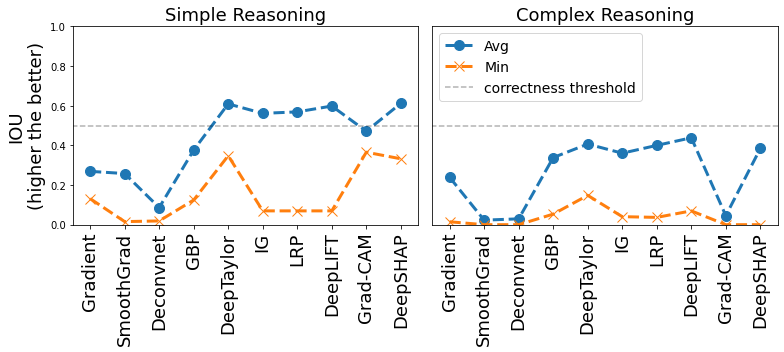

In [12]:
# Main Figure (over buckets)
import glob
method_idx = [0, 1, 2, 3, 4, 6, 8, 11, 13, 14]
methods_sel = [methods[i] for i in method_idx]
methods_sel = [methods[i] for i in method_idx]
methods_sel = ['Gradient', 
'SmoothGrad',
 'Deconvnet',
 'GBP',
 'DeepTaylor',
 'IG',
 'LRP',
 'DeepLIFT',
 'Grad-CAM',
 'DeepSHAP',]
simple_case_nos = [1.11,2.11]
complex_case_nos = [1.2, 3.71, 3.72, 3.73, 3.74]

def compute_valid_minmaxavg(arr):
    # ignore invalid ones and compute avg and std
    no_images, no_methods, no_values = arr.shape
    out = []
    for i in range(no_values):
        tt = arr[:,:,i]
        tt = tt[~(tt == -1).any(axis=1)]
        out.append((np.mean(tt, axis=0), np.std(tt, axis=0), np.min(tt,axis=0), np.max(tt,axis=0)))
    return out
 
metric_type = 'plain_single' # results for plain IOU
p_results = []
s_results = []
for s in simple_case_nos:
    bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_*.npy"%(metric_type, s))))
    ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
    for i in ids:
        d = np.load(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_%d.npy"%(metric_type, s,i)))
        bucket_p, bucket_s = d[0], d[2]
        if not np.isnan(bucket_p[0]):
            p_results.append(bucket_p)
        if not np.isnan(bucket_s[0]):
            s_results.append(bucket_s)
p_results = np.array(p_results)
s_results = np.array(s_results)
simple_avg = np.mean(p_results, axis=0)[method_idx]
simple_min = np.min(p_results, axis=0)[method_idx]

p_results = []
s_results = []
for s in complex_case_nos:
    bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_*.npy"%(metric_type, s))))
    ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
    for i in ids:
        d = np.load(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_%d.npy"%(metric_type, s,i)))
        bucket_p, bucket_s = d[0], d[2]
        if not np.isnan(bucket_p[0]):
            p_results.append(bucket_p)
        if not np.isnan(bucket_s[0]):
            s_results.append(bucket_s)
p_results = np.array(p_results)
s_results = np.array(s_results)
complex_avg = np.mean(p_results, axis=0)[method_idx]
complex_min = np.min(p_results, axis=0)[method_idx]

fig, axs = plt.subplots(1,2, figsize=(11,5))
axs[0].plot(simple_avg, '--', marker='o', markersize=10, label='Avg', linewidth=3)
axs[0].plot(simple_min, '--', marker='x', markersize=10, label='Min', linewidth=3)
axs[0].plot([-1, 10], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs[0].set_ylim([0, 1.0])
axs[0].set_xlim([-0.5, 9.5])
axs[0].set(xticks=[0,1,2,3,4,5,6,7,8,9], xticklabels=methods_sel)
axs[0].set_xticklabels(methods_sel, rotation=90, fontsize=18)
axs[0].set_title('Simple Reasoning', fontsize=18)
if metric_type == 'plain_single':
    axs[0].set_ylabel('IOU\n(higher the better)', fontsize=18)
elif metric_type == 'afl':
    axs[0].set_ylabel('Attribution Focus Level\n(higher the better)', fontsize=18)

axs[1].plot(complex_avg,  '--', marker='o', markersize=10,label='Avg', linewidth=3)
axs[1].plot(complex_min, '--', marker='x', markersize=10,label='Min', linewidth=3)
axs[1].plot([-1, 10], [0.5,0.5], 'k--', alpha=0.3, label='correctness threshold')
axs[1].set_ylim([0, 1.0])
axs[1].set_yticks(())
axs[1].set_xlim([-0.5, 9.5])
axs[1].set(xticks=[0,1,2,3,4,5,6,7,8,9], xticklabels=methods_sel)
axs[1].set_xticklabels(methods_sel, rotation=90, fontsize=18)
axs[1].legend(fontsize=14, loc='upper left')
axs[1].set_title('Complex Reasoning', fontsize=18)
plt.tight_layout()
#plt.savefig(os.path.join(PLOT_DIR, 'result_main_buckets_%s.pdf'%(metric_type)), dpi=200)

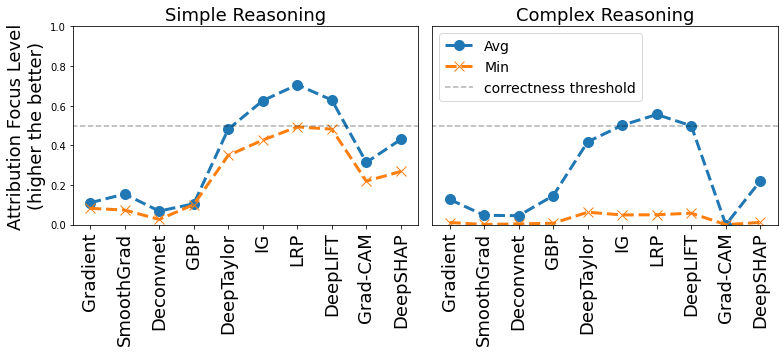

In [13]:
metric_type = 'weighted' # results for AFL
p_results = []
s_results = []
for s in simple_case_nos:
    bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_*.npy"%(metric_type, s))))
    ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
    for i in ids:
        d = np.load(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_%d.npy"%(metric_type, s,i)))
        bucket_p, bucket_s = d[0], d[2]
        if not np.isnan(bucket_p[0]):
            p_results.append(bucket_p)
        if not np.isnan(bucket_s[0]):
            s_results.append(bucket_s)
p_results = np.array(p_results)
s_results = np.array(s_results)
simple_avg = np.mean(p_results, axis=0)[method_idx]
simple_min = np.min(p_results, axis=0)[method_idx]

p_results = []
s_results = []
for s in complex_case_nos:
    bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_*.npy"%(metric_type, s))))
    ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
    for i in ids:
        d = np.load(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_%d.npy"%(metric_type, s,i)))
        bucket_p, bucket_s = d[0], d[2]
        if not np.isnan(bucket_p[0]):
            p_results.append(bucket_p)
        if not np.isnan(bucket_s[0]):
            s_results.append(bucket_s)
p_results = np.array(p_results)
s_results = np.array(s_results)
complex_avg = np.mean(p_results, axis=0)[method_idx]
complex_min = np.min(p_results, axis=0)[method_idx]
complex_avg = np.nan_to_num(complex_avg)
complex_min = np.nan_to_num(complex_min)

fig, axs = plt.subplots(1,2, figsize=(11,5))
axs[0].plot(simple_avg, '--', marker='o', markersize=10, label='Avg', linewidth=3)
axs[0].plot(simple_min, '--', marker='x', markersize=10, label='Min', linewidth=3)
axs[0].plot([-1, 10], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs[0].set_ylim([0, 1.0])
axs[0].set_xlim([-0.5, 9.5])
axs[0].set(xticks=[0,1,2,3,4,5,6,7,8,9], xticklabels=methods_sel)
axs[0].set_xticklabels(methods_sel, rotation=90, fontsize=18)
axs[0].set_title('Simple Reasoning', fontsize=18)
if metric_type == 'plain_single':
    axs[0].set_ylabel('IOU\n(higher the better)', fontsize=18)
elif metric_type == 'weighted':
    axs[0].set_ylabel('Attribution Focus Level\n(higher the better)', fontsize=18)

axs[1].plot(complex_avg,  '--', marker='o', markersize=10,label='Avg', linewidth=3)
axs[1].plot(complex_min, '--', marker='x', markersize=10,label='Min', linewidth=3)
axs[1].plot([-1, 10], [0.5,0.5], 'k--', alpha=0.3, label='correctness threshold')
axs[1].set_ylim([0, 1.0])
axs[1].set_yticks(())
axs[1].set_xlim([-0.5, 9.5])
axs[1].set(xticks=[0,1,2,3,4,5,6,7,8,9], xticklabels=methods_sel)
axs[1].set_xticklabels(methods_sel, rotation=90, fontsize=18)
axs[1].legend(fontsize=14, loc='upper left')
axs[1].set_title('Complex Reasoning', fontsize=18)
plt.tight_layout()
#plt.savefig(os.path.join(PLOT_DIR, 'result_main_buckets_%s.pdf'%(metric_type)), dpi=200)

## Minimal PAFL Comparison: Simple vs Complex

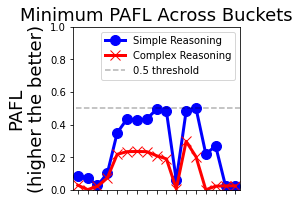

In [14]:
metric_type = 'weighted' # AFL results
#metric_type = 'plain_single' # uncomment this line to get results for plain IOU
p_results = []
s_results = []
for s in simple_case_nos:
    bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_*.npy"%(metric_type, s))))
    ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
    for i in ids:
        d = np.load(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_%d.npy"%(metric_type, s,i)))
        bucket_p, bucket_s = d[0], d[2]
        if not np.isnan(bucket_p[0]):
            p_results.append(bucket_p)
        if not np.isnan(bucket_s[0]):
            s_results.append(bucket_s)
p_results = np.array(p_results)
s_results = np.array(s_results)
simple_avg = np.mean(p_results, axis=0)
simple_min = np.min(p_results, axis=0)

p_results = []
s_results = []
for s in [3.72,3.73]:
    bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_*.npy"%(metric_type, s))))
    ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
    for i in ids:
        d = np.load(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_%d.npy"%(metric_type, s,i)))
        bucket_p, bucket_s = d[0], d[2]
        if not np.isnan(bucket_p[0]):
            p_results.append(bucket_p)
        if not np.isnan(bucket_s[0]):
            s_results.append(bucket_s)
p_results = np.array(p_results)
s_results = np.array(s_results)
complex_avg = np.mean(p_results, axis=0)
complex_min = np.min(p_results, axis=0)
complex_avg = np.nan_to_num(complex_avg)
complex_min = np.nan_to_num(complex_min)

fig, axs = plt.subplots(1,1, figsize=(3,3))
axs.plot(simple_min, 'b-', marker='o', markersize=10, label='Simple Reasoning', linewidth=3)
axs.plot(complex_min, 'r-', marker='x', markersize=10, label='Complex Reasoning', linewidth=3)
axs.plot([-1, len(methods)], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs.set_ylim([0, 1.0])
# axs[0].set_ylim([0, 0.006])
#axs.set(xticks=range(len(methods)), xticklabels=methods)
#axs.set_xticklabels(methods, rotation=90, fontsize=18)
axs.set_xticks(())
axs.set_xlim([-0.5, len(methods)-0.5])
if metric_type == 'plain_single':
    axs.set_title('Minimum PIOU Across Buckets', fontsize=18)
    axs.set_ylabel('IOU\n(higher the better)', fontsize=18)
elif metric_type == 'weighted':
    axs.set_title('Minimum PAFL Across Buckets', fontsize=18)
    axs.set_ylabel('PAFL\n(higher the better)', fontsize=18)
axs.set_xticks(range(simple_min.shape[0]))
axs.set_xticklabels(())
axs.legend()
plt.savefig(os.path.join(PLOT_DIR, 'minimum_change_%s.pdf'%(metric_type)), dpi=200, bbox_inches='tight')

## PAFL / SAFL For All Methods (Mean, StdDev) for Simple Reasoning

../outputs/cache/metrics_plain_single_1.11_8.npy
../outputs/cache/metrics_plain_single_1.11_9.npy
../outputs/cache/metrics_plain_single_1.11_10.npy
../outputs/cache/metrics_plain_single_1.11_11.npy
../outputs/cache/metrics_plain_single_1.11_6.npy
../outputs/cache/metrics_plain_single_1.11_7.npy
../outputs/cache/metrics_plain_single_2.11_2.npy
../outputs/cache/metrics_plain_single_2.11_3.npy
../outputs/cache/metrics_plain_single_2.11_6.npy
../outputs/cache/metrics_plain_single_2.11_7.npy
../outputs/cache/metrics_plain_single_2.11_0.npy
../outputs/cache/metrics_plain_single_2.11_1.npy
../outputs/cache/metrics_plain_single_2.11_4.npy
../outputs/cache/metrics_plain_single_2.11_5.npy


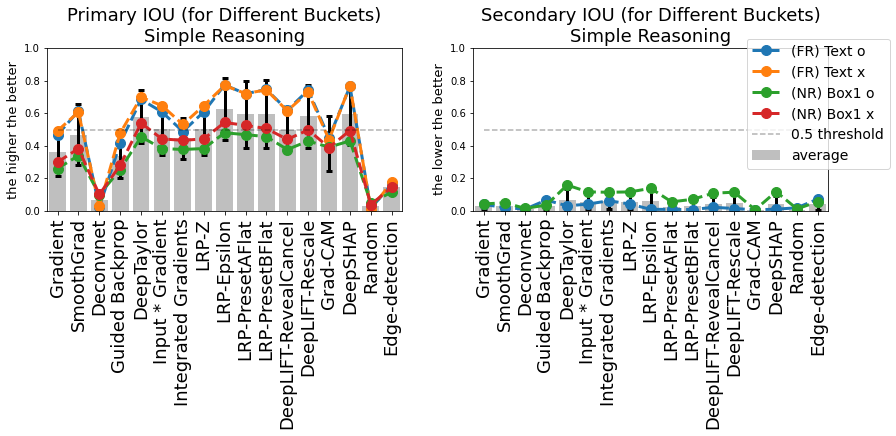

In [10]:
# Simple case: both primary and secondary AFLs
method_idx = range(len(methods))
simple_case_nos = [1.11, 2.11]

#metric_type = 'weighted'
metric_type = 'plain_single' ## uncomment this line to get results for plain IOU metric

p_results = []
s_results = []
for s in simple_case_nos:
    bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_*.npy"%(metric_type, s))))
    ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
    for i in ids:
        d = np.load(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_%d.npy"%(metric_type, s,i)))
        bucket_p, bucket_s = d[0], d[2]
        if not np.isnan(bucket_p[0]):
            p_results.append(bucket_p)
        if not np.isnan(bucket_s[0]):
            s_results.append(bucket_s)
p_results = np.array(p_results)
s_results = np.array(s_results)
simple_avg, simple_std = np.mean(p_results, axis=0), np.std(p_results, axis=0)
simple_avg2, simple_std2 = np.mean(s_results, axis=0), np.std(s_results, axis=0)

f, axs = plt.subplots(1,2, figsize=(7*2, 3))
axs[0].bar(methods, simple_avg, yerr=simple_std, color='grey', alpha=0.5, \
           ecolor='black', error_kw=bar_fig, label='average')
axs[1].bar(methods, simple_avg2, yerr=simple_std2, color='grey', alpha=0.5, \
           ecolor='black', error_kw=bar_fig, label='average')

buckets = [[8,9,10,11], [6,7]]
cluster_label = ['(FR) Text o', '(FR) Text x']
for c, b in enumerate(buckets):
    data1 = np.zeros((len(b), len(methods)))
    data2 = np.zeros((len(b), len(methods)))
    for i, bid in enumerate(b):
        fn = os.path.join(CACHE_DIR, 'metrics_%s_1.11_%d.npy'%(metric_type, bid))
        print(fn)
        tmp = np.load(fn)
        data1[i, :] = tmp[0]
        data2[i, :] = tmp[2]
    data1 = np.mean(data1, axis=0)
    data2 = np.mean(data2, axis=0)
    axs[0].plot(data1, '--', marker='o', label=cluster_label[c], markersize=10, linewidth=3)    
    axs[1].plot(data2, '--', marker='o', label=cluster_label[c], markersize=10, linewidth=3)
    
buckets = [[2,3,6,7], [0,1,4,5]]
cluster_label = ['(NR) Box1 o', '(NR) Box1 x']
for c, b in enumerate(buckets):
    data1 = np.zeros((len(b), len(methods)))
    data2 = np.zeros((len(b), len(methods)))
    for i, bid in enumerate(b):
        fn = os.path.join(CACHE_DIR, 'metrics_%s_2.11_%d.npy'%(metric_type, bid))
        print(fn)
        tmp = np.load(fn)
        data1[i, :] = tmp[0]
        data2[i, :] = tmp[2]
    data1 = np.mean(data1, axis=0)
    data2 = np.mean(data2, axis=0)
    axs[0].plot(data1, '--', marker='o', label=cluster_label[c], markersize=10, linewidth=3)    
    axs[1].plot(data2, '--', marker='o', label=cluster_label[c], markersize=10, linewidth=3)

axs[0].plot([0, len(methods)], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs[0].set_ylim([0, 1])
axs[0].set(xticks=range(len(methods)), xticklabels=methods)
axs[0].set_xticklabels(methods, rotation=90, fontsize=18)
axs[0].set_xlim([-0.5, len(methods)-0.5])
axs[0].set_ylabel('the higher the better', rotation=90, fontsize=13)
if metric_type == 'weighted':
    axs[0].set_title('Primary AFL (for Different Buckets)\nSimple Reasoning', fontsize=18)
elif metric_type == 'plain_single':
    axs[0].set_title('Primary IOU (for Different Buckets)\nSimple Reasoning', fontsize=18)

axs[1].plot([0, len(methods)], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs[1].set_ylim([0, 1])
axs[1].set(xticks=range(len(methods)), xticklabels=methods)
axs[1].set_xticklabels(methods, rotation=90, fontsize=18)
axs[1].set_xlim([-0.5, len(methods)-0.5])
axs[1].set_ylabel('the lower the better', rotation=90, fontsize=13)
if metric_type == 'weighted':
    axs[1].set_title('Secondary AFL (for Different Buckets)\nSimple Reasoning', fontsize=18)
elif metric_type == 'plain_single':
    axs[1].set_title('Secondary IOU (for Different Buckets)\nSimple Reasoning', fontsize=18)
axs[1].legend(loc='upper left', bbox_to_anchor=(0.75, 1.1), fontsize=14)
#plt.savefig(os.path.join(PLOT_DIR, 'simple_results_buckets_%s.pdf'%metric_type), bbox_inches='tight', dpi=200)

## PAFL / SAFL For All Methods (Mean, StdDev) for Complex Reasoning

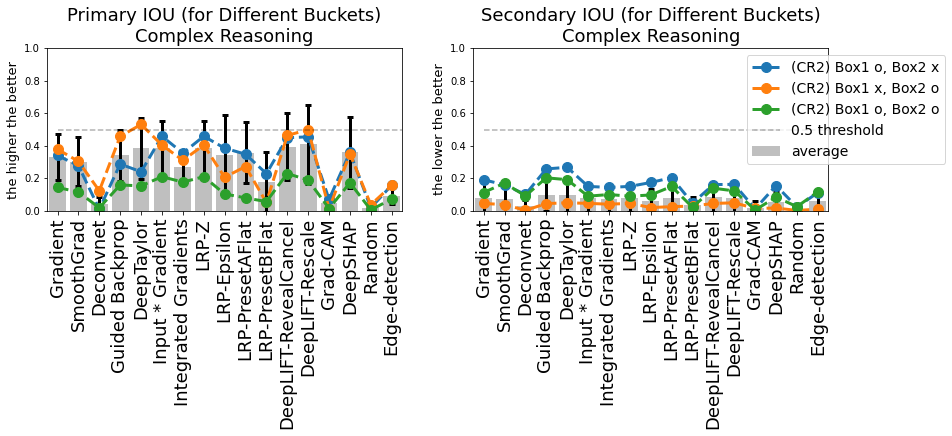

In [11]:
# Complex case: both primary and secondary AFLs
method_idx = range(len(methods))
complex_case_noes = [1.2, 3.71, 3.72, 3.73, 3.74]
        
#metric_type = 'weighted'
metric_type = 'plain_single' # uncomment this line to get results for plain IOU metric
p_results = []
s_results = []
for s in complex_case_noes:
    bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_*.npy"%(metric_type, s))))
    ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
    for i in ids:
        d = np.load(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_%d.npy"%(metric_type, s,i)))
        bucket_p, bucket_s = d[0], d[2]
        if not np.isnan(bucket_p[0]):
            p_results.append(bucket_p)
        if not np.isnan(bucket_s[0]):
            s_results.append(bucket_s)
p_results = np.array(p_results)
s_results = np.array(s_results)
complex_avg, complex_std = np.mean(p_results, axis=0), np.std(p_results, axis=0)
complex_avg2, complex_std2 = np.mean(s_results, axis=0), np.std(s_results, axis=0)
complex_avg, complex_std = np.nan_to_num(complex_avg), np.nan_to_num(complex_std)
complex_avg2, complex_std2 = np.nan_to_num(complex_avg2), np.nan_to_num(complex_std2)

f, axs = plt.subplots(1,2, figsize=(7*2, 3))
axs[0].bar(methods, complex_avg, yerr=complex_std, color='grey', alpha=0.5, \
           ecolor='black', error_kw=bar_fig, label='average')
axs[1].bar(methods, complex_avg2, yerr=complex_std2, color='grey', alpha=0.5, \
           ecolor='black', error_kw=bar_fig, label='average')

# Bucket info
buckets = [[3,4], [5,6], [8,9]]
cluster_label = ['(CR2) Box1 o, Box2 x', '(CR2) Box1 x, Box2 o', '(CR2) Box1 o, Box2 o']
for c, b in enumerate(buckets):
    data1 = np.zeros((len(b), len(methods)))
    data2 = np.zeros((len(b), len(methods)))
    for i, bid in enumerate(b):
        fn = os.path.join(CACHE_DIR, 'metrics_%s_3.72_%d.npy'%(metric_type,bid))
        tmp = np.load(fn)
        data1[i, :] = tmp[0]
        data2[i, :] = tmp[2]
    data1 = np.mean(data1, axis=0)
    data2 = np.mean(data2, axis=0)
    axs[0].plot(data1, '--', marker='o', label=cluster_label[c], markersize=10, linewidth=3)    
    axs[1].plot(data2, '--', marker='o', label=cluster_label[c], markersize=10, linewidth=3)

axs[0].plot([0, len(methods)], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs[0].set_ylim([0, 1])
axs[0].set(xticks=range(len(methods)), xticklabels=methods)
axs[0].set_xticklabels(methods, rotation=90, fontsize=18)
axs[0].set_xlim([-0.5, len(methods)-0.5])
axs[0].set_ylabel('the higher the better', rotation=90, fontsize=13)
if metric_type == 'weighted':
    axs[0].set_title('Primary AFL (for Different Buckets)\nComplex Reasoning', fontsize=18)
elif metric_type == 'plain_single':
    axs[0].set_title('Primary IOU (for Different Buckets)\nComplex Reasoning', fontsize=18)

axs[1].plot([0, len(methods)], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs[1].set_ylim([0, 1])
axs[1].set(xticks=range(len(methods)), xticklabels=methods)
axs[1].set_xticklabels(methods, rotation=90, fontsize=18)
axs[1].set_xlim([-0.5, len(methods)-0.5])
axs[1].set_ylabel('the lower the better', rotation=90, fontsize=13)
if metric_type == 'weighted':
    axs[1].set_title('Secondary AFL (for Different Buckets)\nComplex Reasoning', fontsize=18)
elif metric_type == 'plain_single':
    axs[1].set_title('Secondary IOU (for Different Buckets)\nComplex Reasoning', fontsize=18)
axs[1].legend(loc='upper left',  bbox_to_anchor=(0.75, 1), fontsize=14)
#plt.savefig(os.path.join(PLOT_DIR, 'complex_results_bucket_%s.pdf'%metric_type), bbox_inches='tight', dpi=200)

## Complex Reasoning: individual examples - CR1, CR3, CR4, FR

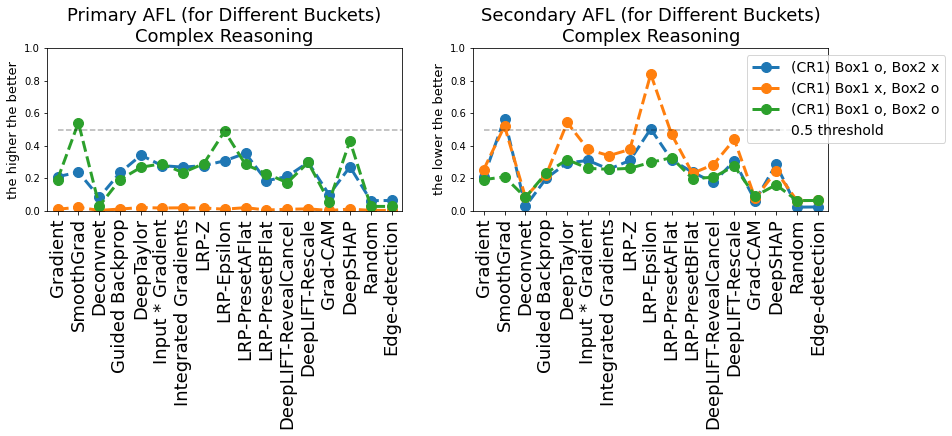

In [8]:
# CR1
method_idx = range(len(methods))
complex_case_noes = [1.2, 3.71, 3.72, 3.73, 3.74]
        
metric_type = 'weighted'
#metric_type = 'plain_single'
p_results = []
s_results = []
for s in complex_case_noes:
    bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_*.npy"%(metric_type, s))))
    ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
    for i in ids:
        d = np.load(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_%d.npy"%(metric_type, s,i)))
        bucket_p, bucket_s = d[0], d[2]
        if not np.isnan(bucket_p[0]):
            p_results.append(bucket_p)
        if not np.isnan(bucket_s[0]):
            s_results.append(bucket_s)
p_results = np.array(p_results)
s_results = np.array(s_results)
complex_avg, complex_std = np.mean(p_results, axis=0), np.std(p_results, axis=0)
complex_avg2, complex_std2 = np.mean(s_results, axis=0), np.std(s_results, axis=0)
complex_avg, complex_std = np.nan_to_num(complex_avg), np.nan_to_num(complex_std)
complex_avg2, complex_std2 = np.nan_to_num(complex_avg2), np.nan_to_num(complex_std2)

f, axs = plt.subplots(1,2, figsize=(7*2, 3))
#axs[0].bar(methods, complex_avg, yerr=complex_std, color='grey', alpha=0.5, \
#           ecolor='black', error_kw=bar_fig, label='average')
#axs[1].bar(methods, complex_avg2, yerr=complex_std2, color='grey', alpha=0.5, \
#           ecolor='black', error_kw=bar_fig, label='average')

# Bucket info
buckets = [[2,3], [5,6], [8,9]]
cluster_label = ['(CR1) Box1 o, Box2 x', '(CR1) Box1 x, Box2 o', '(CR1) Box1 o, Box2 o']
for c, b in enumerate(buckets):
    data1 = np.zeros((len(b), len(methods)))
    data2 = np.zeros((len(b), len(methods)))
    for i, bid in enumerate(b):
        fn = os.path.join(CACHE_DIR, 'metrics_%s_3.71_%d.npy'%(metric_type,bid))
        tmp = np.load(fn)
        data1[i, :] = tmp[0]
        data2[i, :] = tmp[2]
    data1 = np.mean(data1, axis=0)
    data2 = np.mean(data2, axis=0)
    axs[0].plot(data1, '--', marker='o', label=cluster_label[c], markersize=10, linewidth=3)    
    axs[1].plot(data2, '--', marker='o', label=cluster_label[c], markersize=10, linewidth=3)

axs[0].plot([0, len(methods)], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs[0].set_ylim([0, 1])
axs[0].set(xticks=range(len(methods)), xticklabels=methods)
axs[0].set_xticklabels(methods, rotation=90, fontsize=18)
axs[0].set_xlim([-0.5, len(methods)-0.5])
axs[0].set_ylabel('the higher the better', rotation=90, fontsize=13)
if metric_type == 'weighted':
    axs[0].set_title('Primary AFL (for Different Buckets)\nComplex Reasoning', fontsize=18)
elif metric_type == 'plain_single':
    axs[0].set_title('Primary IOU (for Different Buckets)\nComplex Reasoning', fontsize=18)

axs[1].plot([0, len(methods)], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs[1].set_ylim([0, 1])
axs[1].set(xticks=range(len(methods)), xticklabels=methods)
axs[1].set_xticklabels(methods, rotation=90, fontsize=18)
axs[1].set_xlim([-0.5, len(methods)-0.5])
axs[1].set_ylabel('the lower the better', rotation=90, fontsize=13)
if metric_type == 'weighted':
    axs[1].set_title('Secondary AFL (for Different Buckets)\nComplex Reasoning', fontsize=18)
elif metric_type == 'plain_single':
    axs[1].set_title('Secondary IOU (for Different Buckets)\nComplex Reasoning', fontsize=18)
axs[1].legend(loc='upper left',  bbox_to_anchor=(0.75, 1), fontsize=14)
#plt.savefig(os.path.join(PLOT_DIR, 'complex_results_bucket_%s_CR1.pdf'%metric_type), bbox_inches='tight', dpi=200)

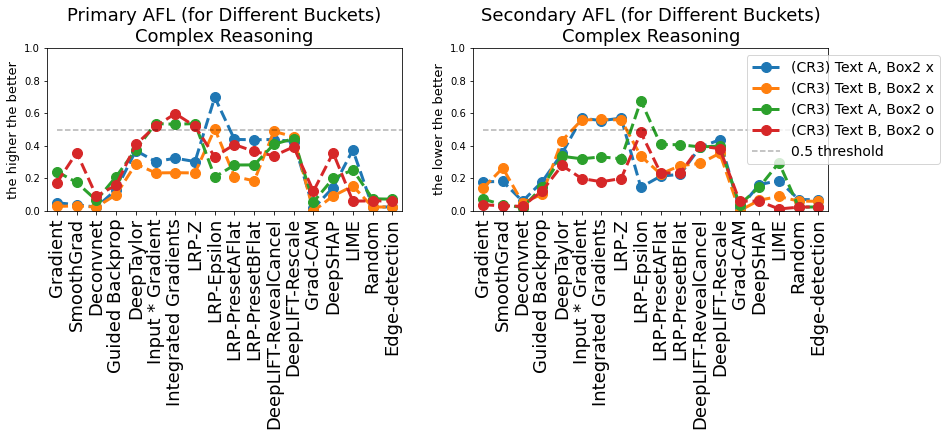

In [24]:
# CR3
f, axs = plt.subplots(1,2, figsize=(7*2, 3))

# Bucket info
buckets = [[4], [5], [8], [9]]
cluster_label = ['(CR3) Text A, Box2 x', '(CR3) Text B, Box2 x', '(CR3) Text A, Box2 o', '(CR3) Text B, Box2 o']
for c, b in enumerate(buckets):
    data1 = np.zeros((len(b), len(methods)))
    data2 = np.zeros((len(b), len(methods)))
    for i, bid in enumerate(b):
        fn = os.path.join(CACHE_DIR, 'metrics_%s_3.73_%d.npy'%(metric_type,bid))
        tmp = np.load(fn)
        data1[i, :] = tmp[0]
        data2[i, :] = tmp[2]
    data1 = np.mean(data1, axis=0)
    data2 = np.mean(data2, axis=0)
    axs[0].plot(data1, '--', marker='o', label=cluster_label[c], markersize=10, linewidth=3)    
    axs[1].plot(data2, '--', marker='o', label=cluster_label[c], markersize=10, linewidth=3)

axs[0].plot([0, len(methods)], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs[0].set_ylim([0, 1])
axs[0].set(xticks=range(len(methods)), xticklabels=methods)
axs[0].set_xticklabels(methods, rotation=90, fontsize=18)
axs[0].set_xlim([-0.5, len(methods)-0.5])
axs[0].set_ylabel('the higher the better', rotation=90, fontsize=13)
if metric_type == 'weighted':
    axs[0].set_title('Primary AFL (for Different Buckets)\nComplex Reasoning', fontsize=18)
elif metric_type == 'plain_single':
    axs[0].set_title('Primary IOU (for Different Buckets)\nComplex Reasoning', fontsize=18)

axs[1].plot([0, len(methods)], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs[1].set_ylim([0, 1])
axs[1].set(xticks=range(len(methods)), xticklabels=methods)
axs[1].set_xticklabels(methods, rotation=90, fontsize=18)
axs[1].set_xlim([-0.5, len(methods)-0.5])
axs[1].set_ylabel('the lower the better', rotation=90, fontsize=13)
if metric_type == 'weighted':
    axs[1].set_title('Secondary AFL (for Different Buckets)\nComplex Reasoning', fontsize=18)
elif metric_type == 'plain_single':
    axs[1].set_title('Secondary IOU (for Different Buckets)\nComplex Reasoning', fontsize=18)
axs[1].legend(loc='upper left',  bbox_to_anchor=(0.75, 1), fontsize=14)
#plt.savefig(os.path.join(PLOT_DIR, 'complex_results_bucket_%s_CR3.pdf'%metric_type), bbox_inches='tight', dpi=200)

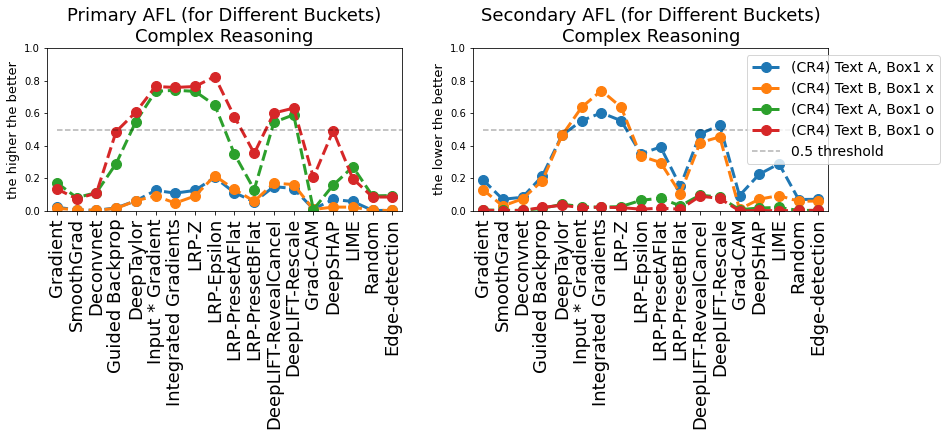

In [25]:
# CR4
f, axs = plt.subplots(1,2, figsize=(7*2, 3))

# Bucket info
buckets = [[6], [7], [8], [9]]
cluster_label = ['(CR4) Text A, Box1 x', '(CR4) Text B, Box1 x', '(CR4) Text A, Box1 o', '(CR4) Text B, Box1 o']
for c, b in enumerate(buckets):
    data1 = np.zeros((len(b), len(methods)))
    data2 = np.zeros((len(b), len(methods)))
    for i, bid in enumerate(b):
        fn = os.path.join(CACHE_DIR, 'metrics_%s_3.74_%d.npy'%(metric_type,bid))
        tmp = np.load(fn)
        data1[i, :] = tmp[0]
        data2[i, :] = tmp[2]
    data1 = np.mean(data1, axis=0)
    data2 = np.mean(data2, axis=0)
    axs[0].plot(data1, '--', marker='o', label=cluster_label[c], markersize=10, linewidth=3)    
    axs[1].plot(data2, '--', marker='o', label=cluster_label[c], markersize=10, linewidth=3)

axs[0].plot([0, len(methods)], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs[0].set_ylim([0, 1])
axs[0].set(xticks=range(len(methods)), xticklabels=methods)
axs[0].set_xticklabels(methods, rotation=90, fontsize=18)
axs[0].set_xlim([-0.5, len(methods)-0.5])
axs[0].set_ylabel('the higher the better', rotation=90, fontsize=13)
if metric_type == 'weighted':
    axs[0].set_title('Primary AFL (for Different Buckets)\nComplex Reasoning', fontsize=18)
elif metric_type == 'plain_single':
    axs[0].set_title('Primary IOU (for Different Buckets)\nComplex Reasoning', fontsize=18)

axs[1].plot([0, len(methods)], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs[1].set_ylim([0, 1])
axs[1].set(xticks=range(len(methods)), xticklabels=methods)
axs[1].set_xticklabels(methods, rotation=90, fontsize=18)
axs[1].set_xlim([-0.5, len(methods)-0.5])
axs[1].set_ylabel('the lower the better', rotation=90, fontsize=13)
if metric_type == 'weighted':
    axs[1].set_title('Secondary AFL (for Different Buckets)\nComplex Reasoning', fontsize=18)
elif metric_type == 'plain_single':
    axs[1].set_title('Secondary IOU (for Different Buckets)\nComplex Reasoning', fontsize=18)
axs[1].legend(loc='upper left',  bbox_to_anchor=(0.75, 1), fontsize=14)
#plt.savefig(os.path.join(PLOT_DIR, 'complex_results_bucket_%s_CR4.pdf'%metric_type), bbox_inches='tight', dpi=200)

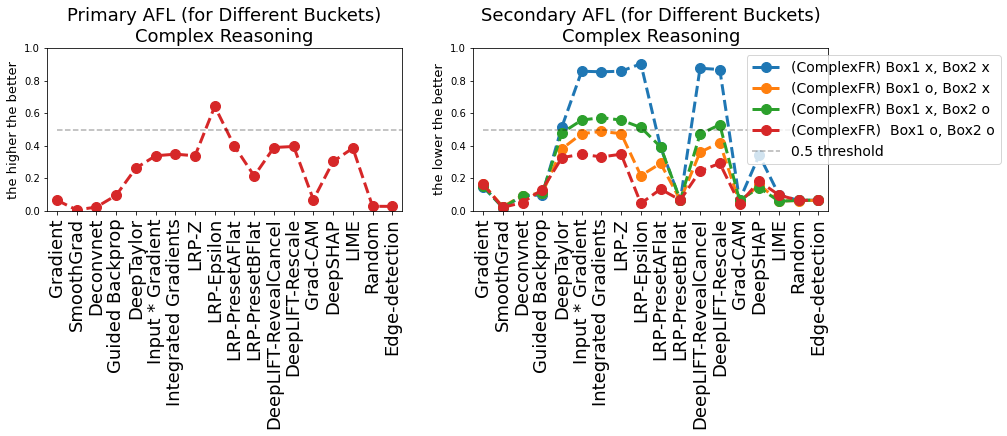

In [26]:
# FR
f, axs = plt.subplots(1,2, figsize=(7*2, 3))

# Bucket info
buckets = [[2,4], [8,10], [3,5], [9,11]]
cluster_label = ['(ComplexFR) Box1 x, Box2 x', '(ComplexFR) Box1 o, Box2 x', '(ComplexFR) Box1 x, Box2 o', '(ComplexFR)  Box1 o, Box2 o']
for c, b in enumerate(buckets):
    data1 = np.zeros((len(b), len(methods)))
    data2 = np.zeros((len(b), len(methods)))
    for i, bid in enumerate(b):
        fn = os.path.join(CACHE_DIR, 'metrics_%s_1.20_%d.npy'%(metric_type,bid))
        tmp = np.load(fn)
        data1[i, :] = tmp[0]
        data2[i, :] = tmp[2]
    data1 = np.mean(data1, axis=0)
    data2 = np.mean(data2, axis=0)
    axs[0].plot(data1, '--', marker='o', label=cluster_label[c], markersize=10, linewidth=3)    
    axs[1].plot(data2, '--', marker='o', label=cluster_label[c], markersize=10, linewidth=3)

axs[0].plot([0, len(methods)], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs[0].set_ylim([0, 1])
axs[0].set(xticks=range(len(methods)), xticklabels=methods)
axs[0].set_xticklabels(methods, rotation=90, fontsize=18)
axs[0].set_xlim([-0.5, len(methods)-0.5])
axs[0].set_ylabel('the higher the better', rotation=90, fontsize=13)
if metric_type == 'weighted':
    axs[0].set_title('Primary AFL (for Different Buckets)\nComplex Reasoning', fontsize=18)
elif metric_type == 'plain_single':
    axs[0].set_title('Primary IOU (for Different Buckets)\nComplex Reasoning', fontsize=18)

axs[1].plot([0, len(methods)], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs[1].set_ylim([0, 1])
axs[1].set(xticks=range(len(methods)), xticklabels=methods)
axs[1].set_xticklabels(methods, rotation=90, fontsize=18)
axs[1].set_xlim([-0.5, len(methods)-0.5])
axs[1].set_ylabel('the lower the better', rotation=90, fontsize=13)
if metric_type == 'weighted':
    axs[1].set_title('Secondary AFL (for Different Buckets)\nComplex Reasoning', fontsize=18)
elif metric_type == 'plain_single':
    axs[1].set_title('Secondary IOU (for Different Buckets)\nComplex Reasoning', fontsize=18)
axs[1].legend(loc='upper left',  bbox_to_anchor=(0.75, 1), fontsize=14)
#plt.savefig(os.path.join(PLOT_DIR, 'complex_results_bucket_%s_complex_FR.pdf'%metric_type), bbox_inches='tight', dpi=200)

## PMAFL / SMAFL Comparison

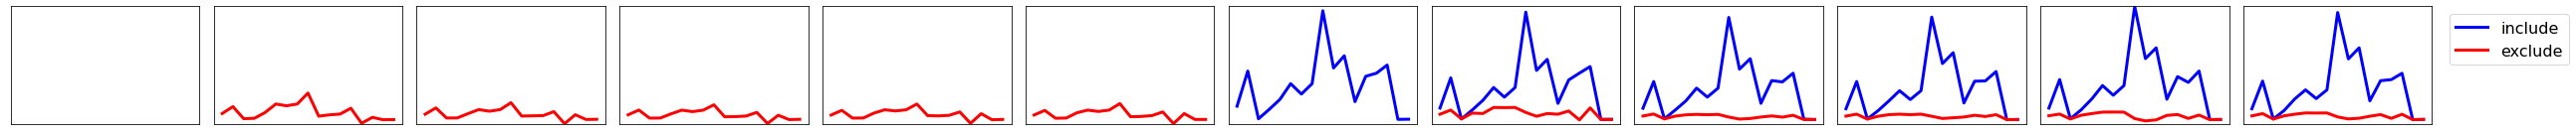

In [12]:
# Simple FR
bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_avg-weighted_1.11_*.npy")))
ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
f, axs = plt.subplots(1, len(bucket_results), figsize=(3 * len(bucket_results), 2))
maxx = -1
for i in ids:
    d = np.load(os.path.join(CACHE_DIR, "metrics_avg-weighted_1.11_%d.npy"%i))
    curr = max(np.max(d[0]), np.max(d[2]))
    if curr > maxx:
        maxx = curr
    axs[i].plot(d[0], label='include', linewidth=3, color='b')
    axs[i].plot(d[2], label='exclude', linewidth=3, color='r')
    axs[i].set_xticks(())
    axs[i].set_yticks(())
for i in ids:
    axs[i].set_ylim([0, maxx])
axs[-1].legend(bbox_to_anchor=(1.05, 1), fontsize=16)
plt.tight_layout()

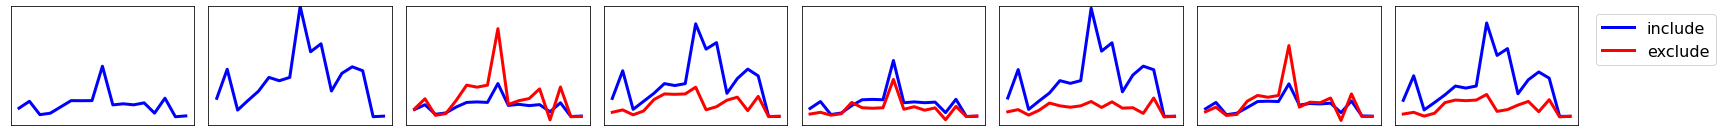

In [13]:
# Simple NR
bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_avg-weighted_2.11_*.npy")))
ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
f, axs = plt.subplots(1, len(bucket_results), figsize=(3 * len(bucket_results), 2))
maxx = -1
for i in ids:
    d = np.load(os.path.join(CACHE_DIR, "metrics_avg-weighted_2.11_%d.npy"%i))
    curr = max(np.max(d[0]), np.max(d[2]))
    if curr > maxx:
        maxx = curr
    axs[i].plot(d[0], label='include', linewidth=3, color='b')
    axs[i].plot(d[2], label='exclude', linewidth=3, color='r')
    axs[i].set_xticks(())
    axs[i].set_yticks(())
for i in ids:
    axs[i].set_ylim([0, maxx])
axs[-1].legend(bbox_to_anchor=(1.05, 1), fontsize=16)
plt.tight_layout()

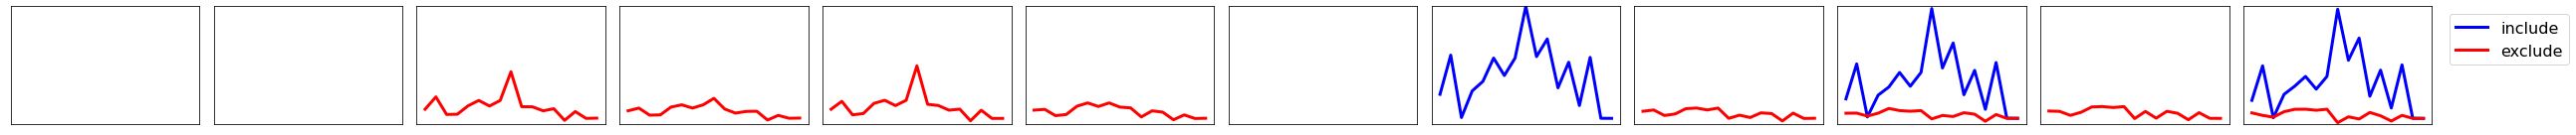

In [14]:
# ComplexFR
bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_avg-weighted_1.20_*.npy")))
ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
f, axs = plt.subplots(1, len(bucket_results), figsize=(3 * len(bucket_results), 2))
maxx = -1
for i in ids:
    d = np.load(os.path.join(CACHE_DIR, "metrics_avg-weighted_1.20_%d.npy"%i))
    curr = max(np.max(d[0]), np.max(d[2]))
    if curr > maxx:
        maxx = curr
    axs[i].plot(d[0], label='include', linewidth=3, color='b')
    axs[i].plot(d[2], label='exclude', linewidth=3, color='r')
    axs[i].set_xticks(())
    axs[i].set_yticks(())
for i in ids:
    axs[i].set_ylim([0, maxx])
axs[-1].legend(bbox_to_anchor=(1.05, 1), fontsize=16)
plt.tight_layout()

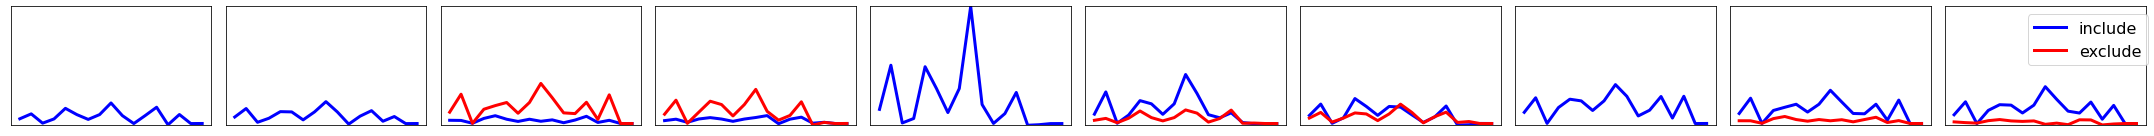

In [15]:
# CR1
bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_avg-weighted_3.71_*.npy")))
ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
f, axs = plt.subplots(1, len(bucket_results), figsize=(3 * len(bucket_results), 2))
maxx = -1
for i in ids:
    d = np.load(os.path.join(CACHE_DIR, "metrics_avg-weighted_3.71_%d.npy"%i))
    curr = max(np.max(d[0]), np.max(d[2]))
    if curr > maxx:
        maxx = curr
    axs[i].plot(d[0], label='include', linewidth=3, color='b')
    axs[i].plot(d[2], label='exclude', linewidth=3, color='r')
    axs[i].set_xticks(())
    axs[i].set_yticks(())
for i in ids:
    axs[i].set_ylim([0, maxx])
axs[-1].legend(bbox_to_anchor=(1.05, 1), fontsize=16)
plt.tight_layout()

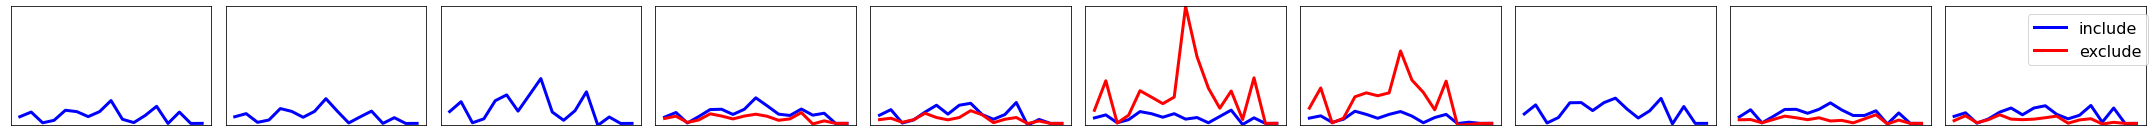

In [16]:
# CR2
bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_avg-weighted_3.72_*.npy")))
ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
f, axs = plt.subplots(1, len(bucket_results), figsize=(3 * len(bucket_results), 2))
maxx = -1
for i in ids:
    d = np.load(os.path.join(CACHE_DIR, "metrics_avg-weighted_3.72_%d.npy"%i))
    d[0] = np.nan_to_num(d[0])
    curr = max(np.max(d[0]), np.max(d[2]))
    if curr > maxx:
        maxx = curr
    axs[i].plot(d[0], label='include', linewidth=3, color='b')
    axs[i].plot(d[2], label='exclude', linewidth=3, color='r')
    axs[i].set_xticks(())
    axs[i].set_yticks(())
for i in ids:
    axs[i].set_ylim([0, maxx])
axs[-1].legend(bbox_to_anchor=(1.05, 1), fontsize=16)
plt.tight_layout()

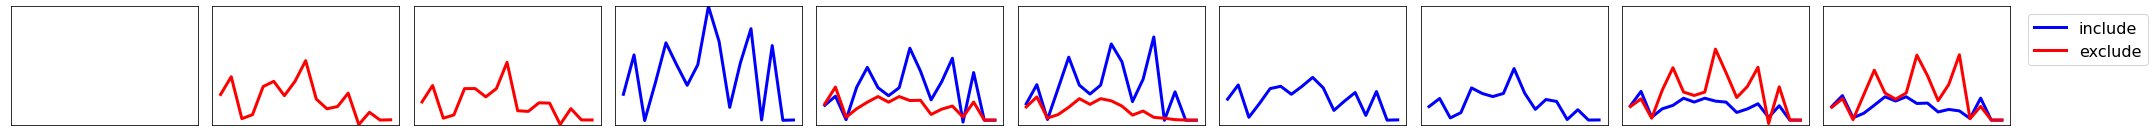

In [17]:
# CR3
bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_avg-weighted_3.73_*.npy")))
ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
f, axs = plt.subplots(1, len(bucket_results), figsize=(3 * len(bucket_results), 2))
maxx = -1
for i in ids:
    d = np.load(os.path.join(CACHE_DIR, "metrics_avg-weighted_3.73_%d.npy"%i))
    curr = max(np.max(d[0]), np.max(d[2]))
    if curr > maxx:
        maxx = curr
    axs[i].plot(d[0], label='include', linewidth=3, color='b')
    axs[i].plot(d[2], label='exclude', linewidth=3, color='r')
    axs[i].set_xticks(())
    axs[i].set_yticks(())
for i in ids:
    axs[i].set_ylim([0, maxx])
axs[-1].legend(bbox_to_anchor=(1.05, 1), fontsize=16)
plt.tight_layout()

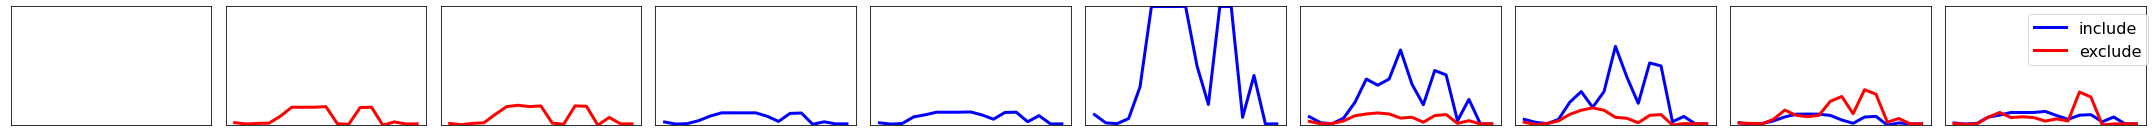

In [13]:
# CR4
bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_avg-weighted_3.74_*.npy")))
ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
f, axs = plt.subplots(1, len(bucket_results), figsize=(3 * len(bucket_results), 2))
maxx = -1
for i in ids:
    d = np.load(os.path.join(CACHE_DIR, "metrics_avg-weighted_3.74_%d.npy"%i))
    curr = max(np.max(d[0]), np.max(d[2]))
    if curr > maxx:
        maxx = curr
    axs[i].plot(d[0], label='include', linewidth=3, color='b')
    axs[i].plot(d[2], label='exclude', linewidth=3, color='r')
    axs[i].set_xticks(())
    axs[i].set_yticks(())
for i in ids:
    axs[i].set_ylim([0, maxx])
axs[-1].legend(bbox_to_anchor=(1.05, 1), fontsize=16)
plt.tight_layout()